In [ ]:
# Wiley Tam
# 500846436
# MASc - Lung Segmentation of CXR Images using Modified U-Net
# EMBC Submission

In [1]:
# Import required libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import cv2

from PIL import Image as pil_img
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
# Google Colab Environment

from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Check that GPU is detected and working

import sys
print (sys.version)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
2.10.1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7244198468306756962
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9547243678162522795
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
# Paths to the input images and target segmentation masks
# Montgomery X-Ray Set
mont_image_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\CXR_png'
mont_left_mask_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\leftMask'
mont_right_mask_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\rightMask'

# Shenzhen X-Ray Set
shen_image_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\CXR_png'
shen_mask_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\ShenzhenMask'

# glob module is used to retrieve files/pathnames matching the specified pattern
# glob can find files recursively hence is used for all the images
mont_image_path = sorted(
    glob(os.path.join(mont_image_dir, '*.png'))
)

mont_left_mask_path = sorted(
    glob(os.path.join(mont_left_mask_dir, '*.png'))
)

mont_right_mask_path = sorted(
    glob(os.path.join(mont_right_mask_dir, '*.png'))
)

shen_image_path = sorted(
    glob(os.path.join(shen_image_dir, '*.png'))
)

shen_mask_path = sorted(
    glob(os.path.join(shen_mask_dir, '*.png'))
)

print("Number of samples from Montgomery X-Ray Dataset:", len(mont_image_path))
print("Number of target masks from Montgomery X-Ray Dataset:", len(mont_left_mask_path))
print('\n')
print("Number of samples from Shenzhen X-Ray Dataset:", len(shen_image_path))
print("Number of target masks from Shenzhen X-Ray Dataset:", len(shen_mask_path))

Number of samples from Montgomery X-Ray Dataset: 138
Number of target masks from Montgomery X-Ray Dataset: 138


Number of samples from Shenzhen X-Ray Dataset: 566
Number of target masks from Shenzhen X-Ray Dataset: 566


In [7]:
# Creating the list of input images
num_montimg = len(mont_image_path)
num_shenimg = len(shen_image_path)
img_list = []

for index in range(0,num_montimg):
  # Preprocess image data
  mont_image = cv2.imread(mont_image_path[index], cv2.IMREAD_COLOR)
  mont_image = cv2.resize(mont_image, (224,224))  
  mont_image = mont_image/255.0
  mont_image = mont_image.astype(np.float32)

  img_list.append(mont_image)

for index in range(0,num_shenimg):
  # Preprocess image data
  shen_image = cv2.imread(shen_image_path[index], cv2.IMREAD_COLOR)
  shen_image = cv2.resize(shen_image, (224,224))  
  shen_image = shen_image/255.0
  shen_image = shen_image.astype(np.float32)

  img_list.append(shen_image)

In [8]:
# Combining the left and right masks
num_montmasks = len(mont_left_mask_path)
num_shenmasks = len(shen_mask_path)
target_mask_list = []
mask_list = []

for index in range(0,num_montmasks):
  mont_left_mask = cv2.imread(mont_left_mask_path[index], cv2.IMREAD_GRAYSCALE)
  mont_right_mask = cv2.imread(mont_right_mask_path[index], cv2.IMREAD_GRAYSCALE)
  mont_mask = mont_left_mask + mont_right_mask

  # Preprocess mask data
  mont_mask = cv2.resize(mont_mask, (224,224))
  mont_mask = mont_mask/np.max(mont_mask)
  mont_mask[mont_mask > 0.5] = 1
  mont_mask[mont_mask <= 0.5] = 0
  target_mask_list.append(mont_mask)
  mont_mask = mont_mask.astype(np.float32)
  mont_mask = np.expand_dims(mont_mask, axis=-1) # Make data into a 3-D Tensor

  mask_list.append(mont_mask)

for index in range(0,num_shenmasks):
  shen_mask = cv2.imread(shen_mask_path[index], cv2.IMREAD_GRAYSCALE)

  # Preprocess mask data
  shen_mask = cv2.resize(shen_mask, (224,224))
  shen_mask = shen_mask/np.max(shen_mask)
  shen_mask[shen_mask > 0.5] = 1
  shen_mask[shen_mask <= 0.5] = 0
  target_mask_list.append(shen_mask)
  shen_mask = shen_mask.astype(np.float32)
  shen_mask = np.expand_dims(shen_mask, axis=-1) # Make data into a 3-D Tensor

  mask_list.append(shen_mask)

In [ ]:
# Display sample images with their target segmentation masks
fig, axs = plt.subplots(2, 2, figsize=(6.5,6.5))
axs[0, 0].set_title('MC X-Ray 1')
axs[0, 0].imshow(img_list[0]) 
axs[0, 1].set_title('MC X-Ray 1 Target Mask')
axs[0, 1].imshow(target_mask_list[0], cmap="gray")
axs[1, 0].set_title('MC X-Ray 138')
axs[1, 0].imshow(img_list[137])
axs[1, 1].set_title('MC X-Ray 138 Target Mask')
axs[1, 1].imshow(target_mask_list[137], cmap="gray")  

fig, axs = plt.subplots(2, 2, figsize=(6.5,6.5))
axs[0, 0].set_title('SH X-Ray 1')
axs[0, 0].imshow(img_list[138]) 
axs[0, 1].set_title('SH X-Ray 1 Target Mask')
axs[0, 1].imshow(target_mask_list[138], cmap="gray")
axs[1, 0].set_title('SH X-Ray 51')
axs[1, 0].imshow(img_list[188])
axs[1, 1].set_title('SH X-Ray 51 Target Mask')
axs[1, 1].imshow(target_mask_list[188], cmap="gray")  

In [9]:
# Splitting image data into training, validation and test
img_train, img_valid, mask_train, mask_valid = train_test_split(
    img_list, mask_list, test_size=0.2, random_state=40
)

img_train, img_test, mask_train, mask_test = train_test_split(
    img_train, mask_train, test_size=0.1, random_state=40
)

print(len(img_train), len(mask_train))
print(len(img_valid), len(mask_valid))
print(len(img_test), len(mask_test))

# Check shapes
print(img_train[0].shape)
print(mask_train[0].shape)

506 506
141 141
57 57
(224, 224, 3)
(224, 224, 1)


In [10]:
# Creating TensorFlow dataset (training and validation)
# Tensorflow dataset generation
# Shuffle and group the train sets into batches
BUFFER_SIZE = 1000
BATCH_SIZE = 2

train_ds = tf.data.Dataset.from_tensor_slices((img_train, mask_train))
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
valid_ds = tf.data.Dataset.from_tensor_slices((img_valid, mask_valid))
valid_ds = valid_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Prefetching with AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Complete Modified U-Net Architecture (DenseResUNet)

################################################################################################################
# Encoder utilities for the U-Net
# Convolutional Block
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):
        # Using Dilated Convolution with a dilation rate of 2
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                kernel_initializer = 'he_normal', padding = 'same', dilation_rate=2)(x)
        #x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
        #        kernel_initializer = 'he_normal', padding = 'same')(x)
        # Implement Batch normalization to improve performance
        # Causes explosive gradient which gets resolved through residual connections
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

    return x

# Residual Block
def res_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    x_bn = tf.keras.layers.BatchNormalization()(x)
    fx_in = tf.keras.layers.Activation('relu')(x)
    fx_in = tf.keras.layers.BatchNormalization()(fx_in)
    fx_in = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same', dilation_rate=2)(fx_in)
    fx_in = tf.keras.layers.BatchNormalization()(fx_in)
    fx_in = tf.keras.layers.Activation('relu')(fx_in)
    fx_in = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same', dilation_rate=2)(fx_in)
    fx_in = tf.keras.layers.BatchNormalization()(fx_in)
    out = tf.keras.layers.Add()([x_bn, fx_in])

    return out

# Transfer Learning - DenseNet201 Backbone
def encoder_dense(inputs):
    # Instantiate ideal ImageNet architecture and use ImageNet pre-trained weights to initialize the model
    Densenet = tf.keras.applications.DenseNet201(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )
    Densenet.trainable = False

    f1 = Densenet.get_layer('input_1').output       #224
    #f1 = tf.keras.layers.Dropout(0.5)(f1)
    f2 = Densenet.get_layer('conv1/relu').output    #112
    #f2 = tf.keras.layers.Dropout(0.5)(f2)
    f3 = Densenet.get_layer('pool2_relu').output    #56
    #f3 = tf.keras.layers.Dropout(0.5)(f3)
    f4 = Densenet.get_layer('pool3_relu').output    #28
    #f4 = tf.keras.layers.Dropout(0.5)(f4)

    f5 = Densenet.get_layer('pool4_relu').output
    #p4 = tf.keras.layers.Dropout(0.5)(p4)
    p6 = Densenet.get_layer('relu').output

    return p6, (f1, f2, f3, f4, f5)
################################################################################################################

################################################################################################################
# Bottleneck 
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)

    return bottle_neck
################################################################################################################

################################################################################################################
# Decoder utilities for the U-Net

# Decoder blocks with up-sampling (deconvolution/tranpose)
def decoder_block(inputs, conv_output, n_filters, kernel_size=3, strides=2, dropout=0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)

    # Residual Block consisting of two applications of convolutional layers with residual connections
    c = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = kernel_size,\
            kernel_initializer = 'he_normal', padding = 'same', dilation_rate=2)(c)
    c = res_block(c, n_filters, kernel_size=3)
    c = res_block(c, n_filters, kernel_size=3)
    c = tf.keras.layers.Activation('relu')(c)

    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4, f5 = convs

    c6 = decoder_block(inputs, f5, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f4, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f3, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f2, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c10 = decoder_block(c9, f1, n_filters=3, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(c10)

    return outputs

# Overall Modified U-Net model
def Modified_UNet():
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    encoder_output, convs = encoder_dense(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs,1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Instantitiate the model and check its summary
model = Modified_UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [5]:
# Evaluation metrics
from tensorflow import keras
from keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 0.00001
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coeff_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
# Defining callback to train the model
# Exit training if IOU reaches above 99%
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            keras.callbacks.ModelCheckpoint('best_model.h5', monitor='iou', mode='max', save_best_only=True, verbose=1)
            if logs.get('iou') >= 0.999:
                print("\nReached 99% IoU - Cancelling training.") 
                # Stop training once the above condition is met
                self.model.stop_training = True
                
# Early Stopping
# es = keras.callbacks.EarlyStopping(monitor='iou', mode='max', verbose=1, min_delta=0.0005, baseline=0.98)

# Model Checkpoint
# mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='iou', mode='max', save_best_only=True, verbose=1)

In [16]:
# Compile and Train the model
# Hyperparameters
num_epochs = 150
learn_rate = 1e-5

#callbacks = myCallback()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learn_rate), loss=dice_coeff_loss,
    metrics=['binary_accuracy', iou, dice_coeff]
)

model_history = model.fit(
    train_ds,
    steps_per_epoch = len(img_train+mask_train)/BATCH_SIZE,
    epochs = num_epochs,
    validation_data = valid_ds,
    validation_steps = len(img_valid+mask_valid)/BATCH_SIZE,
    #callbacks=[callbacks]
)

Epoch 1/150
506/506 [==============================] - 129s 205ms/step - loss: 0.3924 - binary_accuracy: 0.9099 - iou: 0.4380 - dice_coeff: 0.6076 - val_loss: 0.3748 - val_binary_accuracy: 0.9623 - val_iou: 0.4565 - val_dice_coeff: 0.6254
Epoch 2/150
506/506 [==============================] - 97s 191ms/step - loss: 0.3682 - binary_accuracy: 0.9293 - iou: 0.4635 - dice_coeff: 0.6318 - val_loss: 0.3437 - val_binary_accuracy: 0.9606 - val_iou: 0.4899 - val_dice_coeff: 0.6561
Epoch 3/150
506/506 [==============================] - 117s 230ms/step - loss: 0.3469 - binary_accuracy: 0.9426 - iou: 0.4865 - dice_coeff: 0.6531 - val_loss: 0.3342 - val_binary_accuracy: 0.9643 - val_iou: 0.5004 - val_dice_coeff: 0.6655
Epoch 4/150
506/506 [==============================] - 111s 220ms/step - loss: 0.3309 - binary_accuracy: 0.9529 - iou: 0.5044 - dice_coeff: 0.6691 - val_loss: 0.3213 - val_binary_accuracy: 0.9669 - val_iou: 0.5155 - val_dice_coeff: 0.6788
Epoch 5/150
506/506 [========================

In [15]:
# Saving the Model
model.save('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\DenseResUNet_Segmentation_Trained.h5')

In [6]:
# Loading the model
seg_model = tf.keras.models.load_model("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\DenseResUNet_Segmentation_Trained.h5", 
                                       custom_objects={'dice_coeff_loss': dice_coeff_loss, 'iou': iou, 'dice_coeff': dice_coeff})
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# Plot the training and validation loss
def plot_metrics(metric_name, title, ylim=5):
    # plots a given metric from the model history
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [ ]:
# Making predictions using the Model and Test dataset
test_ds = tf.data.Dataset.from_tensor_slices((img_test, mask_test))
test_ds = test_ds.cache().batch(1)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

mask_pred = model.predict(
    test_ds
)


In [ ]:
# Severe case test set
# SH - CXR Image 511 and 603
# MC - CXR Image 266 and 399
TB_img_list = []
TB_msk_list = []

MC_TB_image266 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\CXR_png\\MCUCXR_0266_1.png", cv2.IMREAD_COLOR)
MC_TB_image266 = cv2.resize(MC_TB_image266, (224,224))  
MC_TB_image266 = MC_TB_image266/255.0
MC_TB_image266 = MC_TB_image266.astype(np.float32)

MC_TB_image399 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\CXR_png\\MCUCXR_0399_1.png", cv2.IMREAD_COLOR)
MC_TB_image399 = cv2.resize(MC_TB_image399, (224,224))  
MC_TB_image399 = MC_TB_image399/255.0
MC_TB_image399 = MC_TB_image399.astype(np.float32)

SH_TB_image603 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\CXR_png\\CHNCXR_0603_1.png", cv2.IMREAD_COLOR)
SH_TB_image603 = cv2.resize(SH_TB_image603, (224,224))  
SH_TB_image603 = SH_TB_image603/255.0
SH_TB_image603 = SH_TB_image603.astype(np.float32)

SH_TB_image511 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\CXR_png\\CHNCXR_0511_1.png", cv2.IMREAD_COLOR)
SH_TB_image511 = cv2.resize(SH_TB_image511, (224,224))  
SH_TB_image511 = SH_TB_image511/255.0
SH_TB_image511 = SH_TB_image511.astype(np.float32)

TB_img_list.append(MC_TB_image266)
TB_img_list.append(MC_TB_image399)
TB_img_list.append(SH_TB_image603)
TB_img_list.append(SH_TB_image511)

MCLM_266 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\leftMask\\MCUCXR_0266_1.png", cv2.IMREAD_GRAYSCALE)
MCRM_266 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\rightMask\\MCUCXR_0266_1.png", cv2.IMREAD_GRAYSCALE)
MCM_266 = MCLM_266 + MCRM_266

MCM_266 = cv2.resize(MCM_266, (224,224))
MCM_266 = MCM_266/np.max(MCM_266)
MCM_266[MCM_266 > 0.5] = 1
MCM_266[MCM_266 <= 0.5] = 0
MCM_266 = MCM_266.astype(np.float32)
MCM_266 = np.expand_dims(MCM_266, axis=-1)

MCLM_399 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\leftMask\\MCUCXR_0399_1.png", cv2.IMREAD_GRAYSCALE)
MCRM_399 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\MontgomerySet\\ManualMask\\rightMask\\MCUCXR_0399_1.png", cv2.IMREAD_GRAYSCALE)
MCM_399 = MCLM_399 + MCRM_399

MCM_399 = cv2.resize(MCM_399, (224,224))
MCM_399 = MCM_399/np.max(MCM_399)
MCM_399[MCM_399 > 0.5] = 1
MCM_399[MCM_399 <= 0.5] = 0
MCM_399 = MCM_399.astype(np.float32)
MCM_399 = np.expand_dims(MCM_399, axis=-1)

SHM_603 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\ShenzhenMask\\CHNCXR_0603_1_mask.png", cv2.IMREAD_GRAYSCALE)

SHM_603 = cv2.resize(SHM_603, (224,224))
SHM_603 = SHM_603/np.max(SHM_603)
SHM_603[SHM_603 > 0.5] = 1
SHM_603[SHM_603 <= 0.5] = 0
SHM_603 = SHM_603.astype(np.float32)
SHM_603 = np.expand_dims(SHM_603, axis=-1)

SHM_511 = cv2.imread("C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\ShenzhenSet\\ShenzhenMask\\CHNCXR_0511_1_mask.png", cv2.IMREAD_GRAYSCALE)

SHM_511 = cv2.resize(SHM_511, (224,224))
SHM_511 = SHM_511/np.max(SHM_511)
SHM_511[SHM_511 > 0.5] = 1
SHM_511[SHM_511 <= 0.5] = 0
SHM_511 = SHM_511.astype(np.float32)
SHM_511 = np.expand_dims(SHM_511, axis=-1)

TB_msk_list.append(MCM_266)
TB_msk_list.append(MCM_399)
TB_msk_list.append(SHM_603)
TB_msk_list.append(SHM_511)

print(TB_img_list[0].shape)
print(TB_msk_list[0].shape)

In [ ]:
# Create Tensorflow test dataset with only the TB images/masks and make predictions
TB_test_ds = tf.data.Dataset.from_tensor_slices((TB_img_list, TB_msk_list))
TB_test_ds = TB_test_ds.cache().batch(1)

AUTOTUNE = tf.data.AUTOTUNE
TB_test_ds = TB_test_ds.prefetch(buffer_size=AUTOTUNE)

TB_pred = model.predict(
    TB_test_ds
)

In [ ]:
# Display TB input image with their target segmentation mask and predicted mask
fig, axs = plt.subplots(4, 3, figsize=(10, 10))
axs[0, 0].set_title('X-Ray Image')
axs[0, 0].imshow(TB_img_list[0]) 
axs[0, 1].set_title('Target Mask')
axs[0, 1].imshow(TB_msk_list[0])
axs[0, 2].set_title('Predicted Mask')
axs[0, 2].imshow(TB_pred[0].squeeze(), cmap="gray")

axs[1, 0].set_title('X-Ray Image')
axs[1, 0].imshow(TB_img_list[1])
axs[1, 1].set_title('Target Mask')
axs[1, 1].imshow(TB_msk_list[1])  
axs[1, 2].set_title('Predicted Mask')
axs[1, 2].imshow(TB_pred[1].squeeze(), cmap="gray") 

axs[2, 0].set_title('X-Ray Image')
axs[2, 0].imshow(TB_img_list[2])
axs[2, 1].set_title('Target Mask')
axs[2, 1].imshow(TB_msk_list[2])  
axs[2, 2].set_title('Predicted Mask')
axs[2, 2].imshow(TB_pred[2].squeeze(), cmap="gray") 

axs[3, 0].set_title('X-Ray Image')
axs[3, 0].imshow(TB_img_list[3])
axs[3, 1].set_title('Target Mask')
axs[3, 1].imshow(TB_msk_list[3])  
axs[3, 2].set_title('Predicted Mask')
axs[3, 2].imshow(TB_pred[3].squeeze(), cmap="gray") 

In [ ]:
# Save TB test and predicted images to specified directories
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Predicted')
img_no = 1

for index in range(0,len(TB_pred)):
    pred = plt.imsave('pred_'+str(img_no)+'.png', TB_pred[index].squeeze(), cmap="gray")
    img_no += 1
    
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Images')
img_no = 1

for index in range(0,len(TB_img_list)):
    img = plt.imsave('test_'+str(img_no)+'.png', TB_img_list[index], cmap="gray")
    img_no += 1
    
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Masks')
img_no = 1
TB_msk_list_rgb = []

for index in range(0,len(TB_msk_list)):
    TB_msk_list_rgb.append(cv2.cvtColor(TB_msk_list[index],cv2.COLOR_GRAY2RGB))
    mask = plt.imsave('mask_'+str(img_no)+'.png', TB_msk_list_rgb[index], cmap="gray")
    img_no += 1

In [ ]:
# Final display for the TB cases
for img in range(1, len(TB_pred)+1):
    pred = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Predicted\\pred_' + str(img) + '.png')
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    
    # Apply binary threshold
    ret, pred_thresh = cv2.threshold(pred_gray, 150, 255, cv2.THRESH_BINARY)
    #cv2.imwrite('Threshold_Img.png', pred_thresh)
    
    # Detect contours on binary image
    contours_pred, _ = cv2.findContours(pred_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # Draw contours on copy of original image
    pred_copy = pred.copy()
    cv2.drawContours(pred_copy, contours_pred, -1, (255,0,0), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Contour_Pred')
    cv2.imwrite('ContourPred_' + str(img) + '.png', pred_copy)
    
    # Ground Truth Mask
    gt = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Masks\\mask_' + str(img) + '.png')
    gt_gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    # Apply binary threshold
    ret2, gt_thresh = cv2.threshold(gt_gray, 150, 255, cv2.THRESH_BINARY)
    #cv2.imwrite('GT_Threshold_Img.png', gt_thresh)
    
    # Detect contours on binary image
    # Since findContours wasn't detecting the edge properly, Canny edge detection was used prior
    gt_edges = cv2.Canny(gt,100,200)
    contours_gt, _ = cv2.findContours(gt_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Draw contours on copy of original image
    gt_copy = gt.copy()
    cv2.drawContours(gt_copy, contours_gt, -1, (0,0,255), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Contour_GT')
    cv2.imwrite('ContourGT_' + str(img) + '.png', gt_copy)
    
    # Drawing contours on the original image
    image = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Images\\test_' + str(img) + '.png')
    #image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_copy = image.copy()
    cv2.drawContours(image_copy, contours_pred, -1, (255,0,0), 1, lineType=cv2.LINE_AA)
    cv2.drawContours(image_copy, contours_gt, -1, (0,0,255), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Final_Results')
    cv2.imwrite('Final_' + str(img) + '.png', image_copy)

In [ ]:
# Sample TB Display
# Images in TB_Final_Results
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec

path = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\TB_Final_Results\\'

nrow = 2
ncol = 2

fig = plt.figure(figsize=(ncol+1, nrow+1)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

fig.add_subplot(gs[0,0])
img = mpimg.imread(path + 'Final_1.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[0,1])
img = mpimg.imread(path + 'Final_2.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[1,0])
img = mpimg.imread(path + 'Final_3.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[1,1])
img = mpimg.imread(path + 'Final_4.png')
plt.imshow(img)
plt.axis('off')

In [ ]:
# Save test and predicted images to specified directories
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Predicted')
img_no = 1

for index in range(0,len(mask_pred)):
    pred = plt.imsave('pred_'+str(img_no)+'.png', mask_pred[index].squeeze(), cmap="gray")
    img_no += 1
    
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Images')
img_no = 1

for index in range(0,len(img_test)):
    img = plt.imsave('test_'+str(img_no)+'.png', img_test[index], cmap="gray")
    img_no += 1
    
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Masks')
img_no = 1
mask_test_rgb = []

for index in range(0,len(mask_test)):
    mask_test_rgb.append(cv2.cvtColor(mask_test[index],cv2.COLOR_GRAY2RGB))
    mask = plt.imsave('mask_'+str(img_no)+'.png', mask_test_rgb[index], cmap="gray")
    img_no += 1

In [ ]:
# Post-processing the predicted images
# Hole filling - OpenCV -> morphology
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Predicted')

for img in range(1, len(mask_pred)+1):
    image = cv2.imread('pred_' + str(img) + '.png')
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = (10, 10)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    image_filled = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel)
    
    cv2.imwrite('predfilled_' + str(img) + '.png', image_filled)

In [ ]:
# Change mask image shapes from (H,W,1) to (H,W,3)
# Run once
for index in range(0,len(mask_test)):
    mask_test[index] = np.concatenate([mask_test[index], mask_test[index], mask_test[index]], axis=-1)

In [ ]:
# Display input image with their target segmentation mask and predicted mask
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs[0, 0].set_title('X-Ray Image')
axs[0, 0].imshow(img_test[0]) 
axs[0, 1].set_title('Target Mask')
axs[0, 1].imshow(mask_test[0])
axs[0, 2].set_title('Predicted Mask')
axs[0, 2].imshow(mask_pred[0].squeeze(), cmap="gray")
axs[1, 0].set_title('X-Ray Image')
axs[1, 0].imshow(img_test[10])
axs[1, 1].set_title('Target Mask')
axs[1, 1].imshow(mask_test[10])  
axs[1, 2].set_title('Predicted Mask')
axs[1, 2].imshow(mask_pred[10].squeeze(), cmap="gray") 
axs[2, 0].set_title('X-Ray Image')
axs[2, 0].imshow(img_test[55])
axs[2, 1].set_title('Target Mask')
axs[2, 1].imshow(mask_test[55])  
axs[2, 2].set_title('Predicted Mask')
axs[2, 2].imshow(mask_pred[55].squeeze(), cmap="gray") 

In [ ]:
# Formal results display
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Predicted')

img = cv2.imread("pred_1.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray,50,200)
ret,th2 = cv2.threshold(edges,100,255,cv2.THRESH_BINARY_INV)

cv2.imwrite("img.png",th2)

In [ ]:
# Formal results display - ROUGH
# Canny Edge Detection found edges but drawn on original causes whole lung region to be filled in defined RGB color

pred = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Predicted\\pred_1.png', cv2.IMREAD_GRAYSCALE)
pred_edges = cv2.Canny(pred,100,200)   # canny edge detector

pred = cv2.merge((pred,pred,pred))  # creat RGB image from grayscale
pred_highlight = pred.copy()
pred_highlight[pred_edges == 255] = [255, 0, 0]  # turn edges to red

plt.subplot(121),plt.imshow(pred)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(pred_highlight)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

gt = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Masks\\mask_1.png', cv2.IMREAD_GRAYSCALE)
gt_edges = cv2.Canny(gt,100,200)   # canny edge detector

gt = cv2.merge((gt,gt,gt))  # creat RGB image from grayscale
gt_highlight = gt.copy()
gt_highlight[gt_edges == 255] = [0, 0, 255]  # turn edges to red

plt.subplot(121),plt.imshow(gt)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gt_highlight)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

img = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Images\\test_1.png', cv2.IMREAD_GRAYSCALE)
img = cv2.merge((img,img,img))
img[gt_highlight[:,:,2]==255] = [0,0,255]
#img[pred_highlight[:,:,0]==255] = [255,0,0]

plt.imshow(img)

In [ ]:
# Formal results display - FINAL
# Canny Edge Detection
# Use of Gaussian, Gradient, Non-maxima suppression, and Double Thresholding
# Refer to CPS8207 notes for more details

# Detecting Contour from GT masks and predicted and drawing them on original
#os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc')

# Predicted Image
for img in range(1, len(mask_pred)+1):
    pred = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Predicted\\pred_' + str(img) + '.png')
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    
    # Apply binary threshold
    ret, pred_thresh = cv2.threshold(pred_gray, 150, 255, cv2.THRESH_BINARY)
    #cv2.imwrite('Threshold_Img.png', pred_thresh)
    
    # Detect contours on binary image
    contours_pred, _ = cv2.findContours(pred_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # Draw contours on copy of original image
    pred_copy = pred.copy()
    cv2.drawContours(pred_copy, contours_pred, -1, (255,0,0), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Contour_Pred')
    cv2.imwrite('ContourPred_' + str(img) + '.png', pred_copy)
    
    # Ground Truth Mask
    gt = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Masks\\mask_' + str(img) + '.png')
    gt_gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    # Apply binary threshold
    ret2, gt_thresh = cv2.threshold(gt_gray, 150, 255, cv2.THRESH_BINARY)
    #cv2.imwrite('GT_Threshold_Img.png', gt_thresh)
    
    # Detect contours on binary image
    # Since findContours wasn't detecting the edge properly, Canny edge detection was used prior
    gt_edges = cv2.Canny(gt,100,200)
    contours_gt, _ = cv2.findContours(gt_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Draw contours on copy of original image
    gt_copy = gt.copy()
    cv2.drawContours(gt_copy, contours_gt, -1, (0,0,255), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Contour_GT')
    cv2.imwrite('ContourGT_' + str(img) + '.png', gt_copy)
    
    # Drawing contours on the original image
    image = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Test_Images\\test_' + str(img) + '.png')
    #image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_copy = image.copy()
    cv2.drawContours(image_copy, contours_pred, -1, (255,0,0), 1, lineType=cv2.LINE_AA)
    cv2.drawContours(image_copy, contours_gt, -1, (0,0,255), 1, lineType=cv2.LINE_AA)
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Final_Results')
    cv2.imwrite('Final_' + str(img) + '.png', image_copy)

In [ ]:
# Sample Display
# 2,4,6,8,9,29
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec

path = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Final_Results\\'

nrow = 2
ncol = 3

fig = plt.figure(figsize=(ncol+1, nrow+1)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

fig.add_subplot(gs[0,0])
img = mpimg.imread(path + 'Final_2.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[0,1])
img = mpimg.imread(path + 'Final_4.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[0,2])
img = mpimg.imread(path + 'Final_6.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[1,0])
img = mpimg.imread(path + 'Final_8.png')    
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[1,1])
img = mpimg.imread(path + 'Final_9.png')
plt.imshow(img)
plt.axis('off')

fig.add_subplot(gs[1,2])
img = mpimg.imread(path + 'Final_29.png')
plt.imshow(img)
plt.axis('off')

In [12]:
image_dir1 = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data\\Emphysema'
image_paths1 = sorted(glob(os.path.join(image_dir1, '*.png')))
print("Number of samples in Emp Test Dataset:", len(image_paths1))

image_dir2 = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data\\Normal'
image_paths2 = sorted(glob(os.path.join(image_dir2, '*.png')))
print("Number of samples in Normal Test Dataset:", len(image_paths2))

# os.path.basename grabs the filename portion of the path so 'images.png'
empimgs = []
for i in range(len(image_paths1)):
  empimgs.append(os.path.basename(image_paths1[i]))
  
normimgs = []
for j in range(len(image_paths2)):
    normimgs.append(os.path.basename(image_paths2[j]))
    
print("Number of test Emphysema images:", len(empimgs))
print("Number of test Normal images:", len(normimgs))

Number of samples in Emp Test Dataset: 127
Number of samples in Normal Test Dataset: 257
Number of test Emphysema images: 127
Number of test Normal images: 257


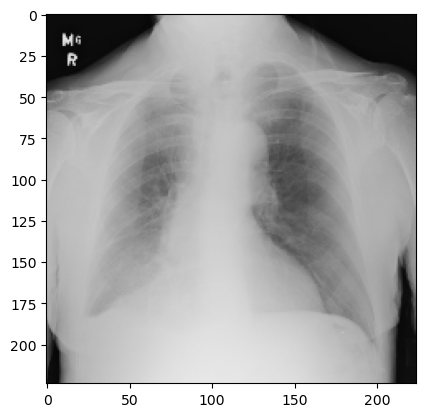

In [29]:
image = cv2.imread(image_paths2[0], cv2.IMREAD_COLOR)
image = cv2.resize(image, (224,224))  
image = image/255.0
image = image.astype(np.float32)
  
plt.figure()
plt.imshow(image)


In [30]:
# Emphysema Classification
# Testing w/ Segmentation Model
Test_list = []

for i in range(len(empimgs)):
    img = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data\\Emphysema\\' + empimgs[i], cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224,224))  
    img = img/255.0
    img = img.astype(np.float32)
    Test_list.append(img)
    
for j in range(len(normimgs)):
    img = cv2.imread('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data\\Normal\\' + normimgs[j], cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224,224))  
    img = img/255.0
    img = img.astype(np.float32)
    Test_list.append(img)

In [31]:
NormEmp_test_ds = tf.data.Dataset.from_tensor_slices(Test_list)
NormEmp_test_ds = NormEmp_test_ds.cache().batch(1)

AUTOTUNE = tf.data.AUTOTUNE
NormEmp_test_ds = NormEmp_test_ds.prefetch(buffer_size=AUTOTUNE)

NormEmp_Pred = seg_model.predict(NormEmp_test_ds)

384/384 [==============================] - 26s 67ms/step


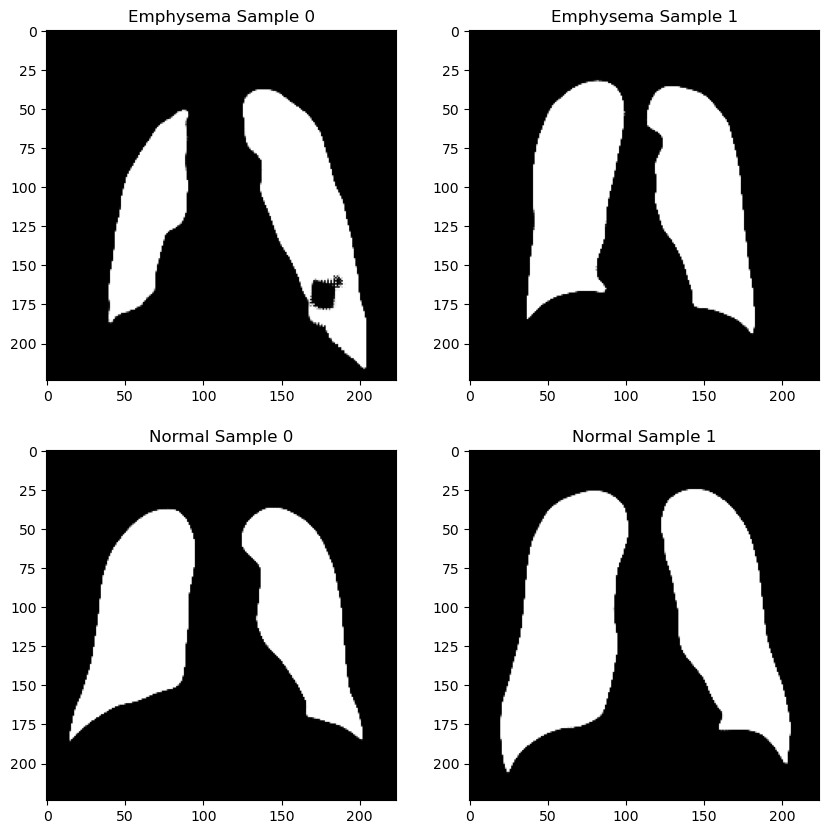

In [38]:
# Plot samples
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].set_title('Emphysema Sample 0')
axs[0, 0].imshow(NormEmp_Pred[0], cmap="gray") 
axs[0, 1].set_title('Emphysema Sample 1')
axs[0, 1].imshow(NormEmp_Pred[1], cmap="gray") 
axs[1, 0].set_title('Normal Sample 2248')
axs[1, 0].imshow(NormEmp_Pred[382], cmap="gray") 
axs[1, 1].set_title('Normal Sample 2249')
axs[1, 1].imshow(NormEmp_Pred[383], cmap="gray") 

In [39]:
# Save TB test and predicted images to specified directories
os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\NormalEmphysema_Predicted')
img_no = 1

for index in range(0,len(NormEmp_Pred)):
    pred = plt.imsave('pred_'+str(img_no)+'.png', NormEmp_Pred[index].squeeze(), cmap="gray")
    img_no += 1

In [62]:
# Hole filling
# Post-processing the predicted images
# Hole filling - OpenCV -> morphology

binary_mask = []
for img in range(1, len(NormEmp_Pred)+1):
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\NormalEmphysema_Predicted')
    image = cv2.imread('pred_' + str(img) + '.png')
    kernel_size = (20, 20)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    image_filled = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    os.chdir('C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\NormalEmphysema_Filled')
    cv2.imwrite('predfilled_' + str(img) + '.png', image_filled)
    binary_mask.append(image_filled)

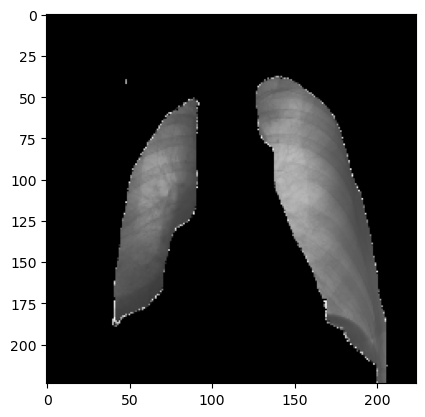

In [68]:
# Final mask from Image*Binary_Mask
# Example
image = cv2.imread(image_paths2[0])
image = cv2.resize(image, (224,224))  
mask = binary_mask[0]

result = (image * mask)

plt.figure()
plt.imshow(result)

# For Emphysema
emp_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data_Seg\Emphysema\\'
for i in range(len(image_paths1)):
    image = cv2.imread(image_paths2[i])
    image = cv2.resize(image, (224,224))  
    mask = binary_mask[i]
    result = (image * mask)
    cv2.imwrite(emp_dir + 'EmpMask_' + str(i) + '.png', result)
    
# For Normal
norm_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data_Seg\\Normal\\'
for i in range(len(image_paths2)):
    image = cv2.imread(image_paths2[i])
    image = cv2.resize(image, (224,224))  
    mask = binary_mask[i+127]
    result = (image * mask)
    cv2.imwrite(norm_dir + 'NormMask_' + str(i) + '.png', result)


In [69]:
# Emphysema Classification w/ Segmentation
# Preprocess the data and create tensors for TensorFlow
img_height = 224
img_width = 224
n_classes = 2
channels = 3
batch_size = 8

# Google Colab
#data_dir = '/content/drive/MyDrive/COPD_Detection_Emphysema/Dataset/Data'

# Laptop workspace
data_dir = 'C:\\Users\\Wiley\\OneDrive\\Desktop\\MASc\\Data_Seg'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 384 files belonging to 2 classes.
Using 308 files for training.
Found 384 files belonging to 2 classes.
Using 76 files for validation.
['Emphysema', 'Normal']


In [70]:
# Simple binary classification model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [71]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [72]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 [==============================] - 4s 54ms/step - loss: 0.6807 - accuracy: 0.5779 - val_loss: 0.6784 - val_accuracy: 0.6184
Epoch 2/10
39/39 [==============================] - 1s 17ms/step - loss: 0.6235 - accuracy: 0.6818 - val_loss: 0.6851 - val_accuracy: 0.6184
Epoch 3/10
39/39 [==============================] - 1s 17ms/step - loss: 0.5683 - accuracy: 0.7013 - val_loss: 0.5875 - val_accuracy: 0.6974
Epoch 4/10
39/39 [==============================] - 1s 16ms/step - loss: 0.4387 - accuracy: 0.7922 - val_loss: 0.5999 - val_accuracy: 0.7237
Epoch 5/10
39/39 [==============================] - 1s 17ms/step - loss: 0.3304 - accuracy: 0.8539 - val_loss: 0.6425 - val_accuracy: 0.7105
Epoch 6/10
39/39 [==============================] - 1s 17ms/step - loss: 0.1467 - accuracy: 0.9383 - val_loss: 0.8453 - val_accuracy: 0.6974
Epoch 7/10
39/39 [==============================] - 1s 18ms/step - loss: 0.0423 - accuracy: 0.9870 - val_loss: 1.0550 - val_accuracy: 0.7105
Epoch 8/10
39

In [73]:
# Define testing function
from tensorflow.keras.preprocessing.image import load_img, img_to_array

input_size=(224,224)

def test_model(img):
  test_image = load_img(img)
  test_image= test_image.resize(input_size)
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)

  # Make the prediction
  result = model.predict(test_image)

  if (np.round(result,1)<=0.5):
    verdict="Emphysema"
  else:
    verdict="Normal"

  return print("Predicted Image Value: ", result, "\nDiagnosis: ", verdict) 

In [81]:
# Run test images
test1 = image_paths1[22]
test_model(test1)

test2 = image_paths2[7]
test_model(test2)

1/1 [==============================] - 0s 51ms/step
Predicted Image Value:  [[0.42701957]] 
Diagnosis:  Emphysema
1/1 [==============================] - 0s 27ms/step
Predicted Image Value:  [[0.82818353]] 
Diagnosis:  Normal
